# Detection

In [42]:
# Todo
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim


### Load data and preprocessing

In [43]:
# Sett seed
SEED = 265
torch.manual_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Bildestørrelse
H_in, W_in = 48, 60
# Grid-størrelse
H_out, W_out = 2, 3  

# endre tilbake når ferdig testa 
y_true_train = torch.load("data/data/list_y_true_train.pt") 
y_true_val = torch.load("data/data/list_y_true_val.pt")
y_true_test = torch.load("data/data/list_y_true_test.pt")

def convert_to_grid(y_true_list, H_out=2, W_out=3, img_h=48, img_w=60):
    """
    Konverterer y_true til grid-format og lager dummy-bilder.
    """
    N = len(y_true_list)
    
    # Dummy input-bilder med 1 kanal (grayscale) (N, 1, H_in, W_in)
    dummy_images = torch.rand((N, 1, img_h, img_w))  
    
    # Output grid (N, H_out, W_out, 6)
    y_true_grid = torch.zeros((N, H_out, W_out, 6)) 

    for img_idx, objects in enumerate(y_true_list):
        for obj in objects:
            pc, x, y, w, h, c = obj

            grid_h = int(y * H_out)
            grid_w = int(x * W_out)

            x_local = (x - (grid_w / W_out)) * W_out
            y_local = (y - (grid_h / H_out)) * H_out
            w_local = w * W_out
            h_local = h * H_out

            y_true_grid[img_idx, grid_h, grid_w] = torch.tensor([1, x_local, y_local, w_local, h_local, c])

    return dummy_images, y_true_grid


# Konverter datasettene
train_images, detection_train = convert_to_grid(y_true_train, H_out, W_out)
val_images, detection_val = convert_to_grid(y_true_val, H_out, W_out)
test_images, detection_test = convert_to_grid(y_true_test, H_out, W_out)



### Normalize Images

In [44]:
mean = detection_train.mean()
std = detection_train.std()
transform = transforms.Normalize(mean, std)

# Opprett DataLoader
train_dataset = TensorDataset(train_images, detection_train)
val_dataset = TensorDataset(val_images, detection_val)
test_dataset = TensorDataset(test_images, detection_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Test input format
images, labels = next(iter(train_loader))
print(f"Images shape: {images.shape}, Labels shape: {labels.shape}")



Images shape: torch.Size([32, 1, 48, 60]), Labels shape: torch.Size([32, 2, 3, 6])


In [45]:
class DetectNet(nn.Module):
    def __init__(self, num_classes=2, H_out=2, W_out=3):
        super(DetectNet, self).__init__()

        self.H_out = H_out
        self.W_out = W_out
        self.output_size = (num_classes + 5) * H_out * W_out  # (pc, x, y, w, h, c1, ..., cC)

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
# kan bytte ut fc med conv2d
        self.fc1 = nn.Linear(64 * 6 * 7, 128)
        self.fc2 = nn.Linear(128, self.output_size)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        print(f"Shape etter CNN-lagene: {x.shape}")  # Debugging

        x = x.view(x.shape[0], -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x.view(-1, self.H_out, self.W_out, 7) 
    


In [46]:
   
def detection_loss(y_pred, y_true):
    """
    Loss-funksjon for Object Detection.
    """
    loss_pc = nn.BCEWithLogitsLoss()(y_pred[:, :, :, 0], y_true[:, :, :, 0])  # Deteksjonsloss

    loss_bbox = torch.where(
        y_true[:, :, :, 0] == 1,  
        nn.MSELoss(reduction='none')(y_pred[:, :, :, 1:5], y_true[:, :, :, 1:5]).mean(dim=-1),
        torch.zeros_like(y_true[:, :, :, 0])
    ).mean()

    loss_class = torch.where(
    y_true[:, :, :, 0] == 1,
    nn.CrossEntropyLoss(reduction='none')(
        y_pred[:, :, :, 5:].permute(0, 3, 1, 2),  # Endrer shape fra (N, H, W, C) → (N, C, H, W)
        y_true[:, :, :, -1].long()
    ),
    torch.zeros_like(y_true[:, :, :, 0])
    ).mean()


    return loss_pc + loss_bbox + loss_class



### Training

In [47]:
# trene modellen 
def train_detection_model(model, train_loader, val_loader, num_epochs=50, early_stop_patience=7):
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
    best_val_loss = float("inf")
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            preds = model(images)
            loss = detection_loss(preds, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Validering
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                preds = model(images)
                val_loss += detection_loss(preds, labels).item()

        val_loss /= len(val_loader)
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {total_loss/len(train_loader):.4f} | Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_detection_model.pth")
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print("Early stopping triggered.")
                break

# Initialiser og tren modellen
model = DetectNet().to(DEVICE)
train_detection_model(model, train_loader, val_loader)


Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.S

### Prediction

Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.S

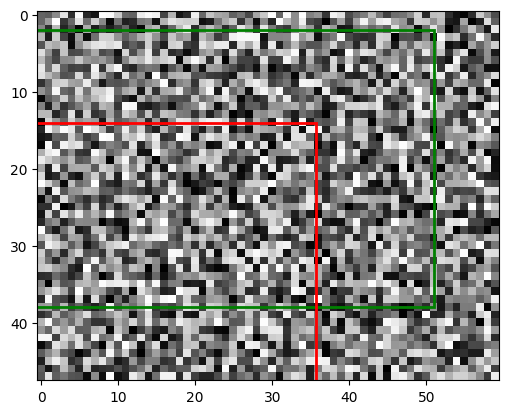

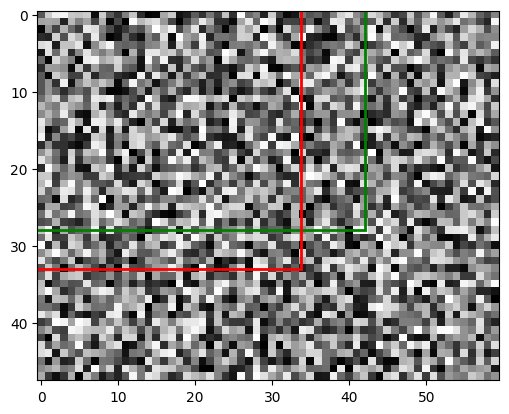

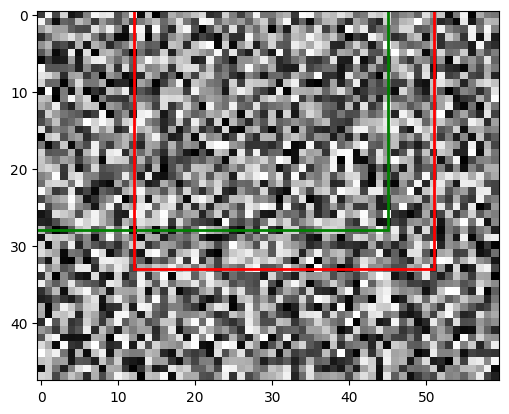

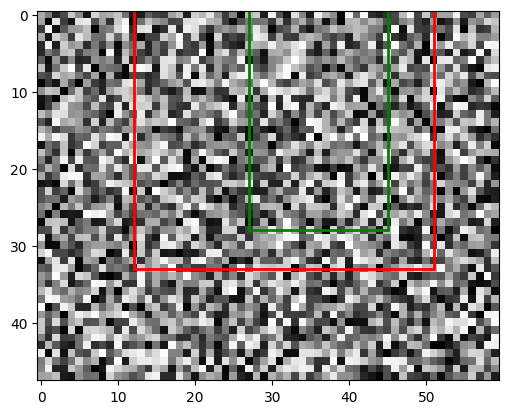

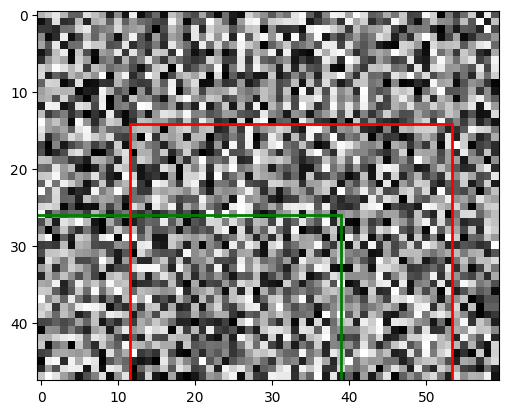

Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])


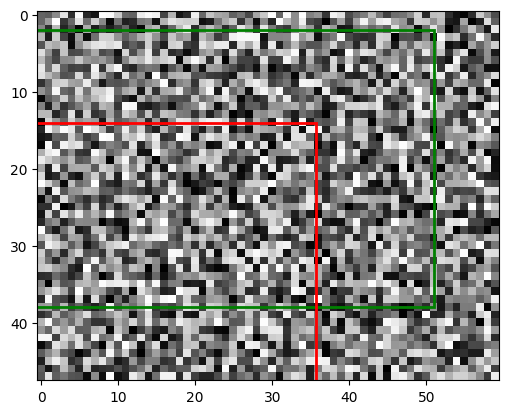

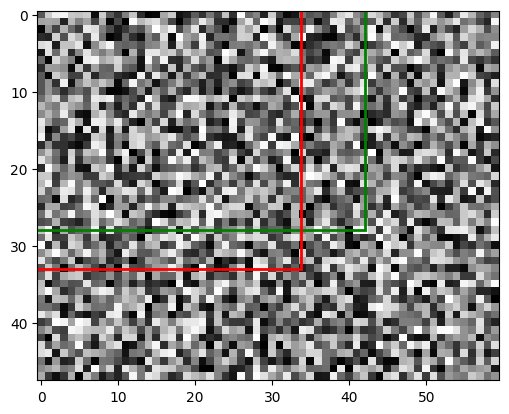

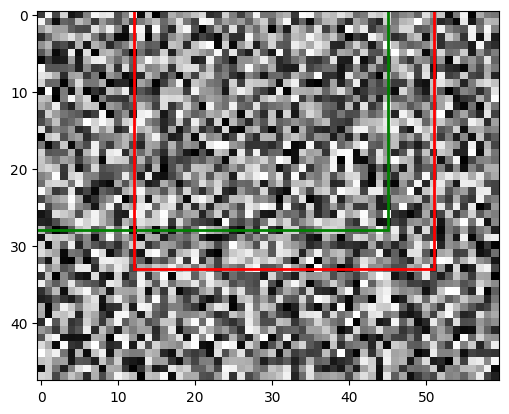

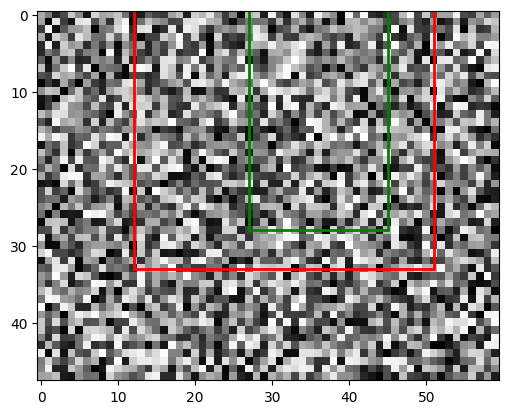

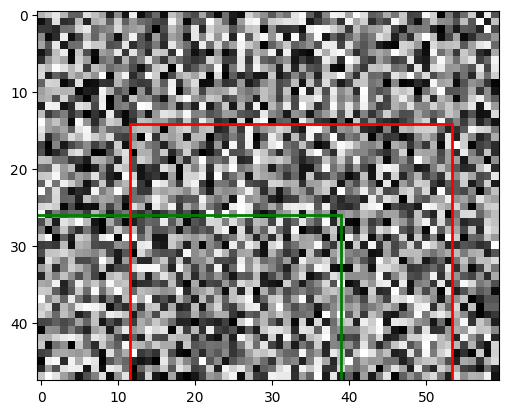

In [53]:
def evaluate_detection_model(model, test_loader):
    """
    Evaluerer modellen på testsettet.
    """
    model.load_state_dict(torch.load("best_detection_model.pth"))
    model.eval()

    test_loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            preds = model(images)
            test_loss += detection_loss(preds, labels).item()

    test_loss /= len(test_loader)
    print(f"Test Loss: {test_loss:.4f}")

# Kjør evaluering
evaluate_detection_model(model, test_loader)


def plot_predictions(model, loader, num_images=5):
    """
    Visualiser sanne og predikerte bounding boxes.
    """
    model.load_state_dict(torch.load("best_detection_model.pth"))
    model.eval()

    images, labels = next(iter(loader))  # Hent en batch
    preds = model(images.to(DEVICE)).cpu().detach()

    for i in range(num_images):
        img = images[i].squeeze().numpy()
        plt.imshow(img, cmap="gray")

        for h in range(H_out):   # Iterer over rader
            for w in range(W_out):  # Iterer over kolonner
                if labels[i, h, w, 0].item() == 0:  # Sjekk om det er et objekt
                    continue  # Hopp over denne grid-cellen

                if labels[i, h, w, 1:5].shape[0] != 4:
                    print(f"⚠️ Advarsel: Feil form på true_bb! shape: {labels[i, h, w, 1:5].shape}")
                    continue  # Hopper over celler uten (x, y, w, h)

                true_bb = labels[i, h, w, 1:5].cpu().numpy()
                pred_bb = preds[i, h, w, 1:5].cpu().numpy()

                # Tegn sann bounding box (grønn)
                plt.gca().add_patch(plt.Rectangle(
                    (true_bb[0] * 60 - true_bb[2] * 30, true_bb[1] * 48 - true_bb[3] * 24),
                    true_bb[2] * 60, true_bb[3] * 48,
                    edgecolor='green', linewidth=2, fill=False))

                # Tegn predikert bounding box (rød)
                plt.gca().add_patch(plt.Rectangle(
                    (pred_bb[0] * 60 - pred_bb[2] * 30, pred_bb[1] * 48 - pred_bb[3] * 24),
                    pred_bb[2] * 60, pred_bb[3] * 48,
                    edgecolor='red', linewidth=2, fill=False))

        plt.show()

# Kjør prediksjonene
plot_predictions(model, test_loader)


# Kjør prediksjonene
plot_predictions(model, test_loader)


### Model selection and evaluation

In [59]:
def IoU(bb1, bb2):
    """
    Beregn Intersection over Union (IoU) mellom to bounding boxes.
    bb1 og bb2 har formatet [x, y, w, h].
    """
    x1_min, y1_min = bb1[0] - bb1[2] / 2, bb1[1] - bb1[3] / 2
    x1_max, y1_max = bb1[0] + bb1[2] / 2, bb1[1] + bb1[3] / 2

    x2_min, y2_min = bb2[0] - bb2[2] / 2, bb2[1] - bb2[3] / 2
    x2_max, y2_max = bb2[0] + bb2[2] / 2, bb2[1] + bb2[3] / 2

    # Finn overlap
    x_inter_min = max(x1_min, x2_min)
    y_inter_min = max(y1_min, y2_min)
    x_inter_max = min(x1_max, x2_max)
    y_inter_max = min(y1_max, y2_max)

    inter_area = max(0, x_inter_max - x_inter_min) * max(0, y_inter_max - y_inter_min)

    # Finn union
    bb1_area = (x1_max - x1_min) * (y1_max - y1_min)
    bb2_area = (x2_max - x2_min) * (y2_max - y2_min)

    union_area = bb1_area + bb2_area - inter_area

    return inter_area / union_area if union_area > 0 else 0

def compute_IoU_detection(model, loader):
    """
    Beregn gjennomsnittlig IoU på testsettet.
    """
    model.eval()
    total_iou = 0
    count = 0

    print("\n🔍 Beregner Intersection over Union (IoU)...")

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            preds = model(images)

            for i in range(len(labels)):
                for h in range(H_out):
                    for w in range(W_out):
                        if labels[i, h, w, 0] == 1:  # Hvis objekt finnes
                            iou = IoU(preds[i, h, w, 1:5].cpu().numpy(), labels[i, h, w, 1:5].cpu().numpy())
                            total_iou += iou
                            count += 1
            
            if batch_idx % 10 == 0:  # Print status hver 10. batch
                print(f"   Batch {batch_idx+1}/{len(loader)} - Akkumulert IoU: {total_iou/count if count > 0 else 0:.4f}")

    avg_iou = total_iou / count if count > 0 else 0
    print(f"\n [RESULTAT] Gjennomsnittlig IoU for modellen: {avg_iou:.4f}")
    return avg_iou



def compute_accuracy_detection(model, loader):
    """
    Beregn klassifikasjonsnøyaktighet.
    """
    model.eval()
    correct = 0
    total = 0

    print("\n Beregner klassifikasjonsnøyaktighet...")

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            preds = model(images)

            for i in range(len(labels)):
                for h in range(H_out):
                    for w in range(W_out):
                        if labels[i, h, w, 0] == 1:  # Kun hvis objekt finnes
                            pred_label = preds[i, h, w, 5:].argmax().item()
                            true_label = labels[i, h, w, -1].item()
                            if pred_label == true_label:
                                correct += 1
                            total += 1

            if batch_idx % 10 == 0:  # Print status hver 10. batch
                print(f"   Batch {batch_idx+1}/{len(loader)} - Akkumulert nøyaktighet: {correct / total if total > 0 else 0:.4f}")

    accuracy = correct / total if total > 0 else 0
    print(f"\n [RESULTAT] Klassifikasjonsnøyaktighet for modellen: {accuracy:.4f}")
    return accuracy



print("\n📊 Starter evaluering av modellen på testsettet...")
iou_score = compute_IoU_detection(model, test_loader)
accuracy_score = compute_accuracy_detection(model, test_loader)

print("\n📌 **Endelig resultat**")
print(f"📏 IoU-score: {iou_score:.4f}")
print(f"🎯 Klassifikasjonsnøyaktighet: {accuracy_score:.4f}\n")




📊 Starter evaluering av modellen på testsettet...

🔍 Beregner Intersection over Union (IoU)...
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
   Batch 1/156 - Akkumulert IoU: 0.3869
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
   Batch 11/156 - Akkumulert IoU: 0.3538
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape etter CNN-lagene: torch.Size([32, 64, 6, 7])
Shape e